# Analysis


In [512]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

# Outliers
from adtk.data import validate_series
from adtk.transformer import DoubleRollingAggregate
from adtk.visualization import plot

## Load data

### dahsboard data

In [514]:
from src import utils

conn = utils.connect_athena(path='../configs/athena.yaml')
df = pd.read_sql_query("""
select 
    *,
    date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.prod_daily_daily_index
where country_iso_code = 'MX' and region_slug = 'country_mexico'
""", conn)

### mobility

In [515]:
df_union=pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/region_city_union.csv") 
df_mean = (df_union
 >> filter(_.date >= '2020-03-23', _.date <= '2020-03-29')
 >> group_by('region_slug', 'measure')
 >> summarize(mean_val = _.value.mean())
 >> ungroup()
)
df_mean.head()
df_scale = (df_union.merge(df_mean.reset_index(), on=['region_slug', 'measure'], how='left')
 >> mutate(value_rescaled = -100*_.value/_.mean_val)
 >> select('region_slug', 'country_name', 'date', 'measure', 'value_rescaled')
 >> spread('measure', 'value_rescaled')
)
df_scale['date'] = df_scale['date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
df_scale.dtypes

region_slug                      object
country_name                     object
date                     datetime64[ns]
pc_driven_miles__waze           float64
tcp__dash                       float64
transit__goo                    float64
workplace__goo                  float64
dtype: object

## Day of week data

In [516]:
df_dow = (df
 >> select( 'region_slug', 'date',  'dow', 'observed', 'tcp') 
 >> mutate( aux_var = (_.dow == 1))
 >> arrange(_.region_slug, _.date)
 >> group_by('region_slug')
 >> mutate( week = _.aux_var.cumsum())
 >> ungroup()
 >> group_by('region_slug', 'week')
 >> mutate( min_date = _.date.min())
 >> ungroup()
 >> select( 'region_slug', 'dow', 'date', 'min_date', 'week', 'observed', 'tcp')
 >> arrange('region_slug', 'dow', 'date')
 >> group_by('region_slug', 'dow')
 >> mutate(tcp_ma = _.tcp.rolling(3).mean(),
           obs_ma = _.observed.rolling(3).mean())
 >> ungroup()          
).dropna()
df_dow['log_observed'] = np.log(df_dow['observed'])
#df_dow.head(2)

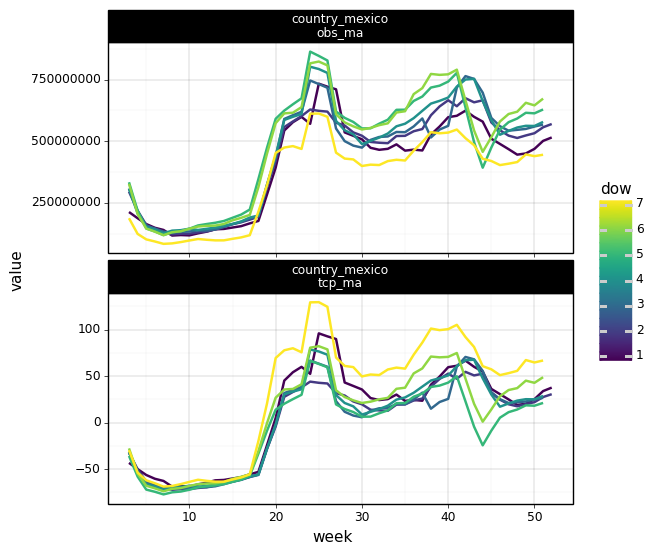

<ggplot: (8757124586701)>

In [517]:
(p9.ggplot(data=(df_dow
                 >> select('region_slug', 'dow', 'date', 'week', 
                           'tcp_ma', 'obs_ma')
                 >> gather('measure', 'value', _["tcp_ma", "obs_ma"])),
           mapping=p9.aes(x='week', y='value', 
                          color = 'dow', group = 'dow')) 
    + p9.geom_line(size=1) 
    + p9.facet_wrap(['region_slug', 'measure'], ncol = 1, scales='free') 
    + p9.theme(figure_size = (6, 6),
                axis_text_x=p9.element_text(angle=0)) )

In [518]:
tab = (df_dow
 >> group_by('region_slug', 'dow')
 >> summarize(n_obs = _.min_date.count())
 >> ungroup()
)
spread(tab, 'dow', 'n_obs')

,region_slug,1,2,3,4,5,6,7
0,country_mexico,50,50,49,49,49,49,49


## Smoothing for day of the week

In [519]:
# train sample
y_df = df_dow \
    .siu_filter(_.dow==1)  \
    .siu_arrange('date') \
    .siu_rename(obs = 'obs_ma') \
    .siu_select('date', 'obs') \
    .set_index('date')
s = validate_series(y_df)

In [520]:
s_transformed = DoubleRollingAggregate(
    agg="std",
    window=(3,2), #The tuple specifies the left window to be 3, and right window to be 1
    center=False,
    diff="l2").transform(s).rename(columns={"obs": "obs_tr"})
df_s=pd.concat([s, s_transformed], axis=1).reset_index()

## Comparison

In [521]:
df_s['baseline']=df_dow \
    .siu_filter(_.date >= '2020-03-23', _.date <= '2020-03-29') \
    .observed.mean()
df_s['tcp_adj'] = 100*(df_s['obs_tr']-df_s['baseline'])/df_s['baseline']
#df_s.head()

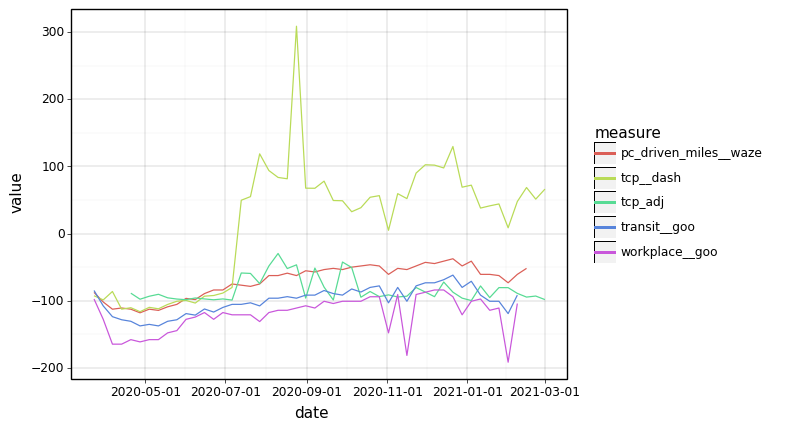

<ggplot: (8757124135361)>

In [522]:
df=df_dow \
    .merge(df_scale, on=['date', 'region_slug'], how='left') \
    .merge(df_s, on='date', how='inner') \
    .siu_select('region_slug', 'date', 
                'tcp_adj', 'tcp__dash',
                'pc_driven_miles__waze', 'transit__goo', 'workplace__goo') \
    .siu_gather('measure', 'value', _['tcp_adj', 'tcp__dash',
                'pc_driven_miles__waze', 'transit__goo', 'workplace__goo'])
(p9.ggplot(data=df,
           mapping=p9.aes(x='date', y='value', color = 'measure')) 
    + p9.geom_line() 
)